# Build a Pipeline with Ensemble Methods 

In [2]:
#workflow and statistics
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt

#for showing missing values
import missingno as msno

#visualisation
import seaborn as sns

#natural language processing toolkit
import nltk
import string
from nltk.corpus import stopwords  # removes useless words
from nltk.stem.lancaster import LancasterStemmer  #converts the words to base form; aggressive
from nltk.stem import porter
from nltk.stem.util import suffix_replace, prefix_replace
from nltk.stem.api import StemmerI
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

#accessing google cloud storage
#from google.cloud import storage
#from io import BytesIO
#client = storage.Client()
#bucket = "bilderkennung_nf_2020"

#import classification models
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier


#build pipeline
import re
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

#evaluation metrics
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score

# Grid search cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from datetime import datetime


# save model
import pickle


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\drena\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
train = pd.read_csv('data/jigsaw-toxic-comment-train.csv')
valid = pd.read_csv('data/validation.csv')

In [9]:
train.shape

(223549, 8)

In [10]:
data_ = {'toxic':[11.4], 'non-toxic':[88.9]}

In [11]:
rel_dist = pd.DataFrame.from_dict(data_)
rel_dist.transpose()

,0
toxic,11.4
non-toxic,88.9


<Figure size 720x432 with 0 Axes>

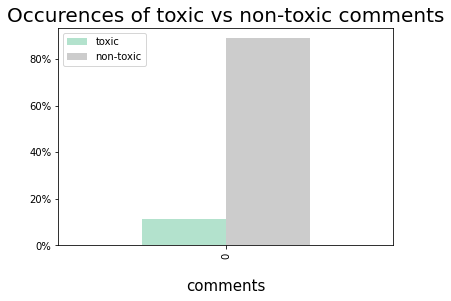

In [12]:
import matplotlib.ticker as mtick

plt.figure(1,figsize=(10,6))
ax = rel_dist.plot(kind='bar', colormap='Pastel2')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Occurences of toxic vs non-toxic comments",fontsize=20)
#plt.ylabel('number of Occurrences', fontsize=15,labelpad=20)
plt.xlabel('comments', fontsize=15,labelpad=20)
plt.show()

**Clean Data**

In [13]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)
train['comment_text'] = train['comment_text'].apply(remove_punctuation)
valid['comment_text'] = valid['comment_text'].apply(remove_punctuation)

In [14]:
sw=stopwords.words('english')
def removesw(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)
train['comment_text'] = train['comment_text'].apply(removesw)
valid['comment_text'] = valid['comment_text'].apply(removesw)

In [15]:
stemmer = SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 
train['comment_text'] = train['comment_text'].apply(stemming)
valid['comment_text'] = valid['comment_text'].apply(stemming)

**Train Test Split**

In [16]:
X = train[['comment_text']]
Y = train['toxic']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

**Preprocess Data**

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.field]
    
#class NumberSelector(BaseEstimator, TransformerMixin):
#    def __init__(self, field):
#        self.field = field
#    def fit(self, X, y=None):
#        return self
#    def transform(self, X):
#        return X[[self.field]]

In [18]:
import nltk

def Tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    porter_stemmer=nltk.PorterStemmer()
    words = [porter_stemmer.stem(word) for word in words]
    return words

After vectorizing the text, if we use the XGBoost classifier we need to add the TruncatedSVD transformer to the pipeline. Its role is to perform linear dimensionality reduction by means of truncated singular value decomposition (SVD). It works on tf-idf matrices generated by sklearn doing what’s called latent semantic analysis (LSA).

# Pipeline

The reason we use a FeatureUnion is to allow us to combine different Pipelines that run on different features of the training data.

In [23]:
models = [
    XGBClassifier, AdaBoostClassifier, RandomForestClassifier
]
for model in models:
    print(str(model))
    pipe = Pipeline([
        (
            'features',
            FeatureUnion([(
                'comment_text',
                Pipeline([
                    ('colext', TextSelector('comment_text')),
                    ('tfidf',
                     TfidfVectorizer(tokenizer=Tokenizer,
                                     min_df=.0025,
                                     max_df=0.25,
                                     ngram_range=(1, 3))),
                    ('svd', TruncatedSVD(algorithm='randomized',
                                         n_components=300)),
                ]))])),
        ('clf', model()),
    ])
    pipe_trained = pipe.fit(X_train, y_train)
    preds = cross_val_predict(pipe, X_train, y_train, cv=5)
    
    # confusion matrix and classification report
    results = confusion_matrix(y_train, preds)
    print('Confusion Matrix :')
    print((results))
    print('Accuracy Score :', accuracy_score(y_train, preds))
    print('Report : ')
    print(classification_report(y_train, preds))

pickle.dump(pipe_trained, open('saved_models/pipe_trained_unsampled.pkl', 'wb'))    

<class 'xgboost.sklearn.XGBClassifier'>
Confusion Matrix :
[[149668   2003]
 [  7583   8407]]
Accuracy Score : 0.942825105421058
Report : 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    151671
           1       0.81      0.53      0.64     15990

    accuracy                           0.94    167661
   macro avg       0.88      0.76      0.80    167661
weighted avg       0.94      0.94      0.94    167661

<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
Confusion Matrix :
[[149425   2246]
 [  8151   7839]]
Accuracy Score : 0.9379879638079219
Report : 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    151671
           1       0.78      0.49      0.60     15990

    accuracy                           0.94    167661
   macro avg       0.86      0.74      0.78    167661
weighted avg       0.93      0.94      0.93    167661

<class 'sklearn.ensemble._forest.RandomFores

Build pipe with seperate preprocessor:

In [19]:
preprocessor = Pipeline([('features', FeatureUnion([(
                'comment_text', Pipeline([
                    ('colext', TextSelector('comment_text')),
                    ('tfidf',
                     TfidfVectorizer(tokenizer=Tokenizer,
                                     min_df=.0025,
                                     max_df=0.25,
                                     ngram_range=(1, 3))),
                    ('svd', TruncatedSVD(algorithm='randomized',
                                         n_components=300))]))]))])

In [20]:
models = [
    XGBClassifier
]
for model in models:
    print(str(model))
    pipe =  Pipeline([('preprocessor', preprocessor), ('classifier', model())] )
  
    pipe_train = pipe.fit(X_train, y_train)
    preds = cross_val_predict(pipe, X_train, y_train, cv=5)
                
    # confusion matrix and classification report
    results = confusion_matrix(y_train, preds)
    print('Confusion Matrix :')
    print((results))
    print('Accuracy Score :', accuracy_score(y_train, preds))
    print('Report : ')
    print(classification_report(y_train, preds))
    
    pickle.dump(pipe_train, open('saved_models/xgb_pipe.pkl', 'wb'))    

<class 'xgboost.sklearn.XGBClassifier'>
Confusion Matrix :
[[149624   2007]
 [  7607   8423]]
Accuracy Score : 0.9426581017648707
Report : 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    151631
           1       0.81      0.53      0.64     16030

    accuracy                           0.94    167661
   macro avg       0.88      0.76      0.80    167661
weighted avg       0.94      0.94      0.94    167661



# RandomSearch

In [21]:
#timer frunction


#def timer(start_time=None):
#    if not start_time:
#        start_time = datetime.now()
#        return start_time
#    elif start_time:
#        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
#        tmin, tsec = divmod(temp_sec, 60)
#        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [22]:
xgb_pipe = Pipeline([('preprocessor', preprocessor), ('classifier', XGBClassifier())])

In [23]:
parameters_xgb = {
    'classifier__max_depth': [2,3],
    'classifier__n_estimators': [100,250,500,750,1000],
    'classifier__learning_rate': [0.1, 0.5, 1, 0.01],
}

In [24]:
# RandomizedSearch CV
folds = 3
param_comb = 5

random_search = RandomizedSearchCV(xgb_pipe, 
                                   param_distributions=parameters_xgb, 
                                   n_iter=param_comb, 
                                   scoring='recall', 
                                   n_jobs=-1, 
                                   cv=5, 
                                   verbose=3, 
                                   random_state=1001 )

In [25]:
# Here we go
#start_time = timer(None) # timing starts from this point for "start_time" variable
RandomSearchXGB = random_search.fit(X_train, y_train)
#timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 359.9min finished


In [26]:
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)

{'mean_fit_time': array([5895.07472243, 1023.69067044, 2177.80043368, 2271.85457268,
       4681.87763872]), 'std_fit_time': array([  98.53900892,    4.81472046,   83.0121392 ,  138.89122108,
       1321.30936692]), 'mean_score_time': array([59.87784781, 56.37920485, 58.92800698, 76.23555655, 48.00360699]), 'std_score_time': array([ 0.99047718,  0.7408452 ,  2.3461705 , 21.03955181, 11.17195148]), 'param_classifier__n_estimators': masked_array(data=[750, 100, 250, 250, 750],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_classifier__max_depth': masked_array(data=[3, 3, 3, 3, 2],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_classifier__learning_rate': masked_array(data=[0.01, 0.5, 0.5, 1, 0.1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'classifier__n_estimators': 750, 'classifier__ma

In [27]:
# confusion matrix and classification report
print('Confusion Matrix :')
print((results))
print('Accuracy Score :', accuracy_score(y_train, preds))
print('Report : ')
print(classification_report(y_train, preds))

Confusion Matrix :
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0    5895.074722     98.539009        59.877848        0.990477   
1    1023.690670      4.814720        56.379205        0.740845   
2    2177.800434     83.012139        58.928007        2.346170   
3    2271.854573    138.891221        76.235557       21.039552   
4    4681.877639   1321.309367        48.003607       11.171951   

  param_classifier__n_estimators param_classifier__max_depth  \
0                            750                           3   
1                            100                           3   
2                            250                           3   
3                            250                           3   
4                            750                           2   

  param_classifier__learning_rate  \
0                            0.01   
1                             0.5   
2                             0.5   
3                               1   
4       

In [28]:
#save model
pickle.dump(RandomSearchXGB.best_estimator_['classifier'], open('saved_models/xgb_best_model_.pkl', 'wb'))


In [29]:
xgb_best = pickle.load(open('saved_models/xgb_best_model_.pkl', 'rb'))

**Testing on Validation Data**

In [31]:
preprocessor.fit(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [32]:
y_test_predicted_xgb = xgb_best.predict(X_test_preprocessed)

In [34]:
results = confusion_matrix(y_test, y_test_predicted_xgb)
print('Confusion Matrix :')
print((results))
print('Accuracy Score :', accuracy_score(y_test, y_test_predicted_xgb))
print('Report : ')
print(classification_report(y_test, y_test_predicted_xgb))

Confusion Matrix :
[[49052  1482]
 [ 2619  2735]]
Accuracy Score : 0.9266210993415402
Report : 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     50534
           1       0.65      0.51      0.57      5354

    accuracy                           0.93     55888
   macro avg       0.80      0.74      0.77     55888
weighted avg       0.92      0.93      0.92     55888

